In [1]:
import numpy as np 
import sys, os
sys.path.append('../Netket/')
import netket as nk
from jax import numpy as jnp
import itertools
from scipy.special import comb
from jax import jit, vmap
import jax
import matplotlib.pyplot as plt 
from cluster_expansion import fwht_coeffs_in_cluster_col_order, prepare_fwht_meta_cached, compress_and_reconstruct_cached, _get_topk_indices_jit
import analysis
from analysis import std_phase, ipr, pca_entropy, renyi_entropy, mean_amplitude, uniform_state_overlap, infidelity
import pandas as pd
from functools import partial

In [2]:
# import functools, importlib
# _orig_lru_cache = functools.lru_cache
# functools.lru_cache = lambda *args, **kwargs: (lambda f: f)   # no-op decorator

# import cluster_expansion
# importlib.reload(cluster_expansion)   # ensures module is loaded with the no-op

# # restore original decorator so other code behaves normally
# functools.lru_cache = _orig_lru_cache

In [3]:
# n_sites_test = 4
# hilb_test = nk.hilbert.Spin(0.5, n_sites_test)


# psi_test = np.random.rand(2**n_sites_test) + 1j * np.random.rand(2**n_sites_test)


# cluster_coeffs_test = fwht_coeffs_in_cluster_col_order(np.log(psi_test), hilb_test)

# # warm-up / measure compile time for a specific num_kept
# k_test = 2**n_sites_test  # you can vary this
# # print(f"Preparing cached meta for n_sites={n_sites_test}...", flush=True)
# prepare_fwht_meta_cached(hilb_test)  # fill cache (fast)

# psi_rec = compress_and_reconstruct_cached(cluster_coeffs_test, k_test, hilb_test)


# mask = _get_topk_indices_jit(cluster_coeffs_test, 2) ## correctly returns the mask
# coeffs_sel = cluster_coeffs_test[mask] ## correctly retruns bigges coeffs



# np.abs(cluster_coeffs_test), np.abs(coeffs_sel), mask, np.isclose(psi_test, psi_rec).all()

In [4]:
hypotheses = {
    "std_phase" : std_phase,
    "IPR" : ipr,
    "SPCA" : pca_entropy,
    "Renyi_2" : renyi_entropy,
    "uniform_state_overlap" : uniform_state_overlap,
    "mean_amplitude" : mean_amplitude,
}

data_root = '..'

h5_files_opt = [os.path.join(f"{data_root}/data/data_optimal_basis_rbm", f) for f in os.listdir(f'{data_root}/data/data_optimal_basis_rbm') if f.endswith('.h5')]
df_opt = analysis.load_outputs_to_dataframe(h5_files_opt, load_eigenstates=False)
df_opt = analysis.attach_hypotheses_fields(df_opt, hypotheses)
df_opt["idx"] = df_opt["file"].apply(lambda x: int(os.path.basename(x).split('_')[2]))
print(len(df_opt))

h5_files_raw = [os.path.join(f"{data_root}/data/data_unrotated_basis_rbm", f) for f in os.listdir(f'{data_root}/data/data_unrotated_basis_rbm') if f.endswith('.h5')]
df_raw = analysis.load_outputs_to_dataframe(h5_files_raw, load_eigenstates=False)
df_raw = analysis.attach_hypotheses_fields(df_raw, hypotheses)
df_raw["idx"] = df_raw["file"].apply(lambda x: int(os.path.basename(x).split('_')[2]))
print(len(df_raw))


230
230


In [5]:
df_raw.head()

,psi,psi_0,Delta_E,E_exact,E_var,infidelity,exact_energies,exact_eigenstates,file,alpha,...,out,seed,show_progress,std_phase,IPR,SPCA,Renyi_2,uniform_state_overlap,mean_amplitude,idx
0,"[(0.0059158155+0.016801007j), (-0.00962411+0.0...",[(-0.023670547568857864-0.005109306986373373j)...,0.004268,-74.147888,-73.831437,0.506029,"[-74.14788800172866, -74.13924266842875, -69.6...",None,../data/data_unrotated_basis_rbm/rbm_optimizat...,1,...,../data/data_unrotated_basis_rbm/rbm_optimizat...,1234,False,1.881749,0.000067,0.982530,9.610145,7.453114e-05,0.003254,63
1,"[(2.887602e-07+1.595124e-06j), (-4.9418657e-07...",[(-1.0336177044070864e-06+1.101748533828067e-0...,0.011558,-59.575424,-58.886826,0.461488,"[-59.575423980097064, -59.40329296112922, -54....",None,../data/data_unrotated_basis_rbm/rbm_optimizat...,1,...,../data/data_unrotated_basis_rbm/rbm_optimizat...,1234,False,1.822105,0.043609,0.556648,3.132500,4.036624e-07,0.000987,186
2,"[(-0.0008381226-0.00049342203j), (-0.001025228...",[(-0.0001597877604745475+0.0007185543200796602...,0.078247,-66.135163,-60.960293,0.568067,"[-66.13516324244779, -65.07129384615259, -64.4...",None,../data/data_unrotated_basis_rbm/rbm_optimizat...,1,...,../data/data_unrotated_basis_rbm/rbm_optimizat...,1234,False,1.824668,0.000109,0.946567,9.126434,3.716983e-07,0.002703,752
3,"[(-8.957938e-05-7.9120524e-05j), (7.400337e-05...",[(1.9591487782967917e-05-0.0001423204464905697...,0.004005,-69.058112,-68.781534,0.505933,"[-69.05811218524704, -69.02662473466664, -61.5...",None,../data/data_unrotated_basis_rbm/rbm_optimizat...,1,...,../data/data_unrotated_basis_rbm/rbm_optimizat...,1234,False,1.803127,0.004439,0.740494,5.417372,7.261689e-07,0.001691,993
4,"[(0.54223126+0.19820093j), (-0.011169789+0.031...","[(-0.026627492081470555+0.5191495935009228j), ...",0.019739,-43.420593,-42.563513,0.076630,"[-43.42059262343188, -42.34937631960235, -40.4...",None,../data/data_unrotated_basis_rbm/rbm_optimizat...,1,...,../data/data_unrotated_basis_rbm/rbm_optimizat...,1234,False,1.783619,0.074983,0.934620,2.590498,8.220288e-06,0.001488,726


In [35]:
n_sites_test = 16
hilb_test = nk.hilbert.Spin(0.5, n_sites_test)
compr_idx_list = sorted(np.array(list(set(np.logspace(1, 16, 100, base=2, dtype=int)))))  


idx = 197
row = df_opt[df_opt.idx == idx].iloc[0]
psi_test_exact = row['psi_0']
psi_test_RBM = row['psi']
cluster_coeffs_test_exact = fwht_coeffs_in_cluster_col_order(np.log(psi_test_exact), hilb_test)
cluster_coeffs_test_RBM = fwht_coeffs_in_cluster_col_order(np.log(psi_test_RBM), hilb_test)

prepare_fwht_meta_cached(hilb_test)  # fill cache (fast)

infidels_exact_opt = [infidelity(compress_and_reconstruct_cached(cluster_coeffs_test_exact, compr_idx, hilb_test), psi_test_exact) 
           for compr_idx in compr_idx_list]
infidels_RBM_opt = [infidelity(compress_and_reconstruct_cached(cluster_coeffs_test_RBM, compr_idx, hilb_test), psi_test_exact) 
           for compr_idx in compr_idx_list]

# mask = _get_topk_indices_jit(cluster_coeffs_test, 5)
# mask, jnp.abs(cluster_coeffs_test[mask])


In [36]:
def get_N_params(Nsites,alpha):
    Nhidden = int(alpha * Nsites)
    Nparams = Nsites * Nhidden + Nsites + Nhidden
    return Nparams

65536


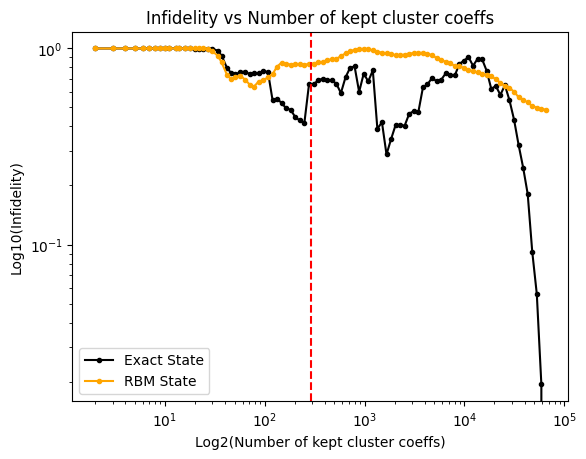

In [37]:
print(max(compr_idx_list))
fig, ax = plt.subplots(1)
ax.plot(compr_idx_list, (infidels_exact_opt), '.-', label='Exact State', color='black')
ax.plot((compr_idx_list), (infidels_RBM_opt), '.-', label='RBM State', color='orange')
ax.set_xlabel('Log2(Number of kept cluster coeffs)')
ax.set_ylabel('Log10(Infidelity)')
ax.set_title('Infidelity vs Number of kept cluster coeffs')
ax.legend()
ax.set_yscale('log')
ax.set_xscale('log')
ax.axvline(get_N_params(np.log2(len(row.psi)), row.alpha), color='red', linestyle='--', label='RBM Params (alpha=4)')
plt.show()

In [32]:
16 ** 2 + 16 * 2
get_N_params(np.log2(len(row.psi)), row.alpha)

np.float64(288.0)

## Show what the state looks like

np.float64(0.07755385593498532)

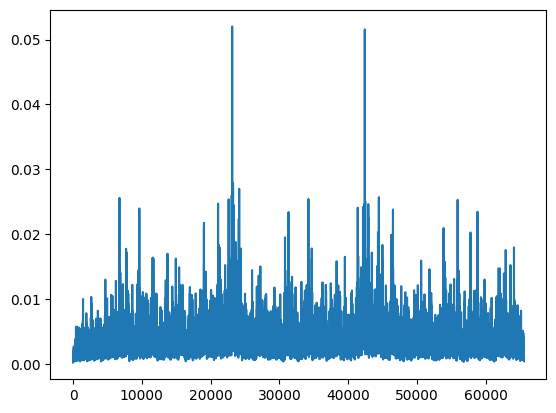

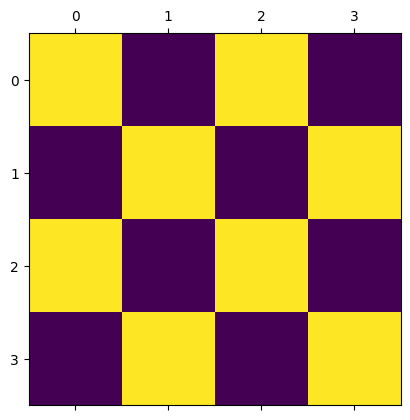

In [20]:
psi_test = df_opt.iloc[0]['psi']
psi_exa = df_opt.iloc[0]['psi_0']
hilbert = nk.hilbert.Spin(s=0.5, N=16)

plt.plot(np.abs(psi_test), label='abs')

order = np.argsort(np.abs(psi_test))[::-1]
state_req = hilbert.numbers_to_states([order[0]])
statemat = np.reshape(state_req, (4,4))
plt.matshow(statemat, 'ro', label='max amp state')


cluster_coeffs_test = fwht_coeffs_in_cluster_col_order(np.log(psi_test), hilbert)
psi_rec = compress_and_reconstruct_cached(cluster_coeffs_test, 10000, hilbert)
infidelity(psi_rec, psi_exa)

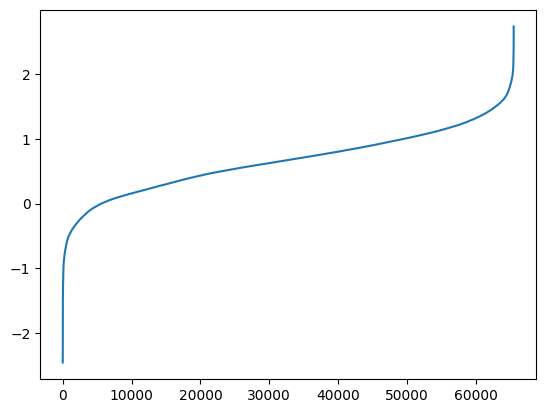

In [34]:
phase_exact = np.angle(psi_test)
perm = np.argsort(phase_exact)

plt.plot(phase_exact[perm])
# plt.plot(np.angle(psi)[perm])

In [10]:
# import functools, importlib
# _orig_lru_cache = functools.lru_cache
# functools.lru_cache = lambda *args, **kwargs: (lambda f: f)   # no-op decorator

# import cluster_expansion
# importlib.reload(cluster_expansion)   # ensures module is loaded with the no-op

# # restore original decorator so other code behaves normally
# functools.lru_cache = _orig_lru_cache

In [50]:
df_opt[0:2].idx.values

array([968, 253])

In [ ]:
def compute_infidelity_matrices(df, hilb, compr_idx_list):
    n_rows = len(df)
    n_compr = len(compr_idx_list)
    infidels_exact_opt_mat = np.zeros((n_rows, n_compr))
    infidels_RBM_opt_mat = np.zeros((n_rows, n_compr))
    for i, row in df.iterrows():
        psi_test_exact = np.array(row['psi_0'])
        psi_test_RBM = np.array(row['psi'])
        cluster_coeffs_test_exact = fwht_coeffs_in_cluster_col_order(np.log(psi_test_exact), hilb)
        cluster_coeffs_test_RBM = fwht_coeffs_in_cluster_col_order(np.log(psi_test_RBM), hilb)
        prepare_fwht_meta_cached(hilb)
        for j, compr_idx in enumerate(compr_idx_list):
            psi_rec_exact = compress_and_reconstruct_cached(cluster_coeffs_test_exact, compr_idx, hilb)
            psi_rec_RBM = compress_and_reconstruct_cached(cluster_coeffs_test_RBM, compr_idx, hilb)
            infidels_exact_opt_mat[i, j] = infidelity(psi_rec_exact, psi_test_exact)
            infidels_RBM_opt_mat[i, j] = infidelity(psi_rec_RBM, psi_test_exact)
    return infidels_exact_opt_mat, infidels_RBM_opt_mat

infidels_exact_opt_mat, infidels_RBM_opt_mat = compute_infidelity_matrices(df_opt, hilb_test, compr_idx_list)

In [56]:
import h5py
outfile = '../data/cluster_expansion_analysis/expansion_infidelities.h5'
import os
os.makedirs(os.path.dirname(outfile), exist_ok=True)
with h5py.File(outfile, 'w') as f:
    f.create_dataset('infidels_exact_opt_mat', data=infidels_exact_opt_mat)
    f.create_dataset('infidels_RBM_opt_mat', data=infidels_RBM_opt_mat)
    f.create_dataset('compr_idx_list', data=compr_idx_list)
    f.create_dataset('idxs', data=df_opt[0:2].idx.values)

In [44]:
df_opt[0:2].idx

0    968
1    253
Name: idx, dtype: int64